In [1]:
import jax
# Global flag to set a specific platform, must be used at startup.
#jax.config.update('jax_platform_name', 'cpu')

import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='False'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.98'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'


In [2]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from jax_unirep import get_reps
  
from jax_unirep import evotune, fit
from jax_unirep.utils import dump_params

In [3]:
import gc
import jax 
def clear_jax_caches():
  """Utility to clear all the function caches in jax."""
  # main jit/pmap lu wrapped function caches - have to grab from closures
  jax.xla._xla_callable.__closure__[1].cell_contents.clear()
  jax.pxla.parallel_callable.__closure__[1].cell_contents.clear()
  # primitive callable caches
  jax.xla.xla_primitive_callable.cache_clear()
  jax.xla.primitive_computation.cache_clear()
  # jaxpr caches for control flow and reductions
  jax.lax.lax_control_flow._initial_style_jaxpr.cache_clear()
  jax.lax.lax_control_flow._fori_body_fun.cache_clear()
  jax.lax.lax._reduction_jaxpr.cache_clear()
  # these are trivial and only included for completeness sake
  jax.lax.lax.broadcast_shapes.cache_clear()
  jax.xla.xb.get_backend.cache_clear()
  jax.xla.xb.dtype_to_etype.cache_clear()
  jax.xla.xb.supported_numpy_dtypes.cache_clear()
    
def reset_device_memory(delete_objs=True):
    """Free all tracked DeviceArray memory and delete objects.

  Args:
    delete_objs: bool: whether to delete all live DeviceValues or just free.

  Returns:
    number of DeviceArrays that were manually freed.
  """
    dvals = (x for x in gc.get_objects() if isinstance(x, jax.xla.DeviceArray))
    n_deleted = 0
    for dv in dvals:
    
        if not isinstance(dv, jax.xla.DeviceConstant):
            try: 
                dv._check_if_deleted()  # pylint: disable=protected-access
                dv.device_buffer.delete()
                n_deleted += 1
            except:
                pass
        if delete_objs:

            del dv
    del dvals
    gc.collect()
    return n_deleted

In [25]:
#db_path="AMPS_NonAMPs.ready.csv"
db_path="../../datasets/newcluster/AMPs_NonAMPs.ready.nr90.csv"# <----- Change here AMPs_NonAMPs.ready.nr70.csv

In [26]:
df=pd.read_csv(db_path,sep=',',header=0,quoting=csv.QUOTE_ALL)
df # Class 0= AMPs , 1=NonAMps

,ID,Sequence,length,class
0,EN92515250|C|B3FJD7|phage 201phi2-1 lysin,MAKKSVPLRKPAGSDGQGNIKVPGGPVVLDLGDFDDIFGPMESESP...,2337,0
1,EN54061055|C|F8SJ56|phage PhiPA3 lysin,MASKKTTLPKPKGINPQGSIVQLDLDDFDDLFDEDFGLPKKNSPYT...,2319,0
2,EN4815120|C|Q8SCY1|phage phiKZ lysin,MAKKVTLPKGQTGATGTTLGQAGNILDLSDVDDIFGDTPKAKKGSP...,2237,0
3,EN3016141|D|D2J8A7|bacteriocin,MAETIKGLRIDLSLKDMGVGRSITELKRSFRTLNSDLKVSSKNFEY...,1619,0
4,EN9175723|BD|Q93IM3|bacteriocin,MAKKKNTYKVPSIIALTLAGTALTTHHAQAADKTQDQSTNKNILND...,1564,0
...,...,...,...,...
26257,UniRef50_A0A323TJX8 VWFD domain-containing pro...,SYLLAKDFVGGDFEVIGEYESVGGLMRLKSVVVRGQGTDVTLHVDG...,380,1
26258,UniRef50_C6WJT6 Response regulator receiver pr...,MSNRRVLMVDDEQRVLDGLRRMLRGRYELTTSVSGAEAIGLVREST...,382,1
26259,UniRef50_A0A1A8A8S0 EH domain binding protein ...,MTSVWKRLQRVGKKASKFQFVASFEELILESCKKWQPDKLRVMWIR...,210,1
26260,UniRef50_F6TRT4 SYCP2_ARLD domain-containing p...,MGTNEKQLENLLRGSDSNKIEEFLQSNLNTPQACGTVFESCLRRVA...,384,1


In [27]:
# Setting my chunk size
chunk_size = 3000
# Assigning chunk numbers to rows
df['chunk'] = df.index.map(lambda x: int(int(x)/ chunk_size))
# We don't want the 'chunk' and 'index' columns in the output
cols = [col for col in df.columns if col not in ['chunk']]
# groupby chunk and export each chunk to a different csv.
i = 0
for _, chunk in df.groupby('chunk'):
    chunk[cols].to_csv(f'/mnt/vdb/thesis/newclus_reps/90/chunk{i}.csv',sep=",", quotechar='"',index=False, quoting=csv.QUOTE_ALL) # <<-- change this line 
    i += 1
print("complete")

complete


In [28]:
def createREPs(df, filename):
    _h_avg, h_final, c_final= get_reps(df['Sequence'].to_list())
    df.drop(columns=['Sequence'], inplace=True)
    df['reps']=_h_avg.tolist() # if there is a problem , might be here , possible solution is reindexing
    df.to_pickle(filename) # dont forget to change the file name to 0_613834

In [29]:
import glob
appended_reps = []
for infile in glob.glob("/mnt/vdb/thesis/newclus_reps/90/*.pkl"): # <<-- change this line 
    # print(infile)
    appended_reps.append(infile)
print(len(appended_reps))

0


In [30]:
for infile in glob.glob("/mnt/vdb/thesis/newclus_reps/90/*.csv"): # <<-- change this line 
    #print("Read:"+infile)
    file_name = os.path.basename(infile)
    result="/mnt/vdb/thesis/newclus_reps/90/"+file_name.replace("csv", "pkl") # <<-- change this line 
    if result in appended_reps :
        # print("found then skip : " , result)
        continue
    else:
        df = pd.read_csv(infile) 
        createREPs(df,result)
        print("Save:"+result)
        reset_device_memory()
        clear_jax_caches()
print("complete")

Save:/mnt/vdb/thesis/newclus_reps/90/chunk8.pkl
Save:/mnt/vdb/thesis/newclus_reps/90/chunk5.pkl
Save:/mnt/vdb/thesis/newclus_reps/90/chunk6.pkl
Save:/mnt/vdb/thesis/newclus_reps/90/chunk2.pkl
Save:/mnt/vdb/thesis/newclus_reps/90/chunk3.pkl
Save:/mnt/vdb/thesis/newclus_reps/90/chunk7.pkl
Save:/mnt/vdb/thesis/newclus_reps/90/chunk1.pkl
Save:/mnt/vdb/thesis/newclus_reps/90/chunk0.pkl
Save:/mnt/vdb/thesis/newclus_reps/90/chunk4.pkl
complete


In [17]:
reset_device_memory()
clear_jax_caches()

In [31]:
def mergeDF(path,to_dir,file_name):
    appended_data = []
    for infile in glob.glob(path):
        #print(infile)
        data = pd.read_pickle(infile)
        # store DataFrame in list
        appended_data.append(data)
    result_path=to_dir+"/"+file_name
    print("Save:",result_path)
    appended_data = pd.concat(appended_data)
    appended_data.sort_values(by=['ID'], inplace=True)
    appended_data.to_pickle(result_path)
    return appended_data

In [32]:
# write result
AMPs_df =mergeDF("/mnt/vdb/thesis/newclus_reps/90/*.pkl","/mnt/vdb/thesis/newclus_reps/90","AMPNonAMP.nr90.reps.plk") # <<-- change this line 
AMPs_df

Save: /mnt/vdb/thesis/newclus_reps/90/AMPNonAMP.nr90.reps.plk


,ID,length,class,reps
2348,0_antitbpred|antitbpred,33,0,"[0.021885791793465614, 0.06677425652742386, 0...."
1560,1000_pos_train_ds3|pos_train_ds3,86,0,"[0.010705526918172836, 0.005044554825872183, 0..."
1032,"10015_dbaasp,10016_dbaasp|dbaasp_peptides",11,0,"[0.20464205741882324, -0.05594474822282791, 0...."
2020,10023_dbaasp|dbaasp_peptides,36,0,"[0.0037219570949673653, -0.07121426612138748, ..."
2088,10029_dbaasp|dbaasp_peptides,14,0,"[0.14606480300426483, 0.041531842201948166, 0...."
...,...,...,...,...
829,dbAMP_12158,17,0,"[0.07279127091169357, 0.05830632895231247, -0...."
1115,dbAMP_12161,16,0,"[0.17415067553520203, 0.11548950523138046, 0.0..."
1693,dbAMP_12203,15,0,"[0.03923531994223595, -0.025372691452503204, -..."
560,dbAMP_12275,53,0,"[0.032192349433898926, -0.07197041809558868, 0..."


Remove Duplicate

## Split train and test set

In [33]:
X= np.array(AMPs_df['reps'].to_list())
y= np.array(AMPs_df['class'].to_list())

In [34]:
X.shape

(26262, 1900)

In [35]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [36]:
len(y_train[y_train == 1])

10511

In [37]:
len(y_train[y_train == 0])

10498

# Implement Toy Model (RF)

In [38]:
from sklearn.ensemble import RandomForestClassifier 

classifier = RandomForestClassifier ( random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2633
           1       0.89      0.89      0.89      2620

    accuracy                           0.89      5253
   macro avg       0.89      0.89      0.89      5253
weighted avg       0.89      0.89      0.89      5253

0.89130020940415


[[2340  293]
 [ 278 2342]]


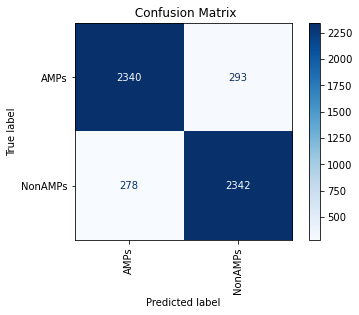

In [40]:
from sklearn.metrics import plot_confusion_matrix

class_names = ['AMPs', 'NonAMPs']

disp = plot_confusion_matrix(classifier, X_test, y_test,
                            display_labels = class_names,
                            cmap=plt.cm.Blues, xticks_rotation='vertical')

disp.ax_.set_title(" Confusion Matrix")

print(disp.confusion_matrix)
plt.grid(False)
plt.show()